# Setup

## Imports and Functions

In [1]:
import numpy as np
print (np.__version__)
import pandas as pd
print (np.__path__)
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
import xgboost as xgb
from sklearn.utils import shuffle
from scipy.stats import skew
from __future__ import division, print_function, unicode_literals
import os

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

1.13.1
['/Users/pieter/Dev/ML/jupieter/env/lib/python3.6/site-packages/numpy']


/Users/pieter/Dev/ML/jupieter/env/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12


In [3]:
def fit_and_score_classifier(model, X, y, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    print(model)
    predictions = model.predict(X_test)
    print("Accuracy: %0.4f" % accuracy_score(y_test, predictions))
    scores = cross_val_score(model, X, y, cv=5)
    oof_predictions_train = cross_val_predict(model, X, y, cv=5)
    print("Cross val accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    return scores, oof_predictions_train.reshape(-1, 1)

## Import Data

In [4]:
train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')

train_labels = train.Survived
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C
290,291,1,1,"Barber, Miss. Ellen ""Nellie""",female,26.0,0,0,19877,78.8500,NaN,S
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,2,0,345764,18.0000,NaN,S
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,367231,7.7500,NaN,Q
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S


In [5]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [6]:
features = pd.concat([train.drop('Survived',1), test], keys=['train', 'test'])

# Explore Data

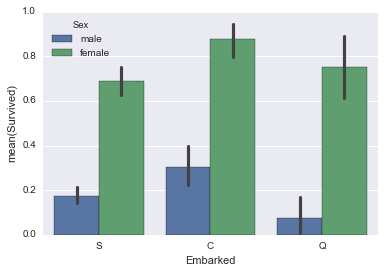

In [7]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train);

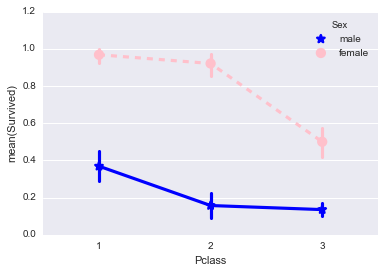

In [8]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

# Imputing missing data

In [9]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0


## Fare

In [10]:
print(test[test['Fare'].isnull()])

     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  


In [11]:
test['Fare'].iloc[152] = features['Fare'][features['Pclass'] == 3].dropna().median()
print(test['Fare'].iloc[152])

8.05


## Embarked

In [12]:
print(train[train['Embarked'].isnull()])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


In [13]:
features.where((features['Embarked'] !='Q') & (features['Pclass'] < 1.5) & \
    (features['Sex'] == "female")).groupby(['Embarked','Pclass','Sex','Parch','SibSp']).size()

Embarked  Pclass  Sex     Parch  SibSp
C         1.0     female  0.0    0.0      30
                                 1.0      20
                          1.0    0.0      10
                                 1.0       6
                          2.0    0.0       2
                                 2.0       2
                          3.0    1.0       1
S         1.0     female  0.0    0.0      20
                                 1.0      20
                                 2.0       3
                          1.0    0.0       7
                                 1.0       6
                          2.0    0.0       4
                                 1.0       5
                                 3.0       3
                          4.0    1.0       1
dtype: int64

In [14]:
train['Embarked'].iloc[61] = "C"
train['Embarked'].iloc[829] = "C"

## Age and Cabin

TODO: Currently don't know what to do with it

In [15]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Age,177,86.0
Cabin,687,327.0


In [16]:
features.isnull().sum().max()

1014

# Feature Engineering

## Fare

## Cabin

In [17]:
def simplify_ages(df):
    df['Child'] = df['Age']<=10
    df['Young'] = (df['Age']<=30) | (df['Title'].isin(['Master','Miss','Mlle']))    
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_fares(df):
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['unkown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    return df    
    
def family_size(dataset):
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset['Large_Family'] = (dataset['SibSp']>2) | (dataset['Parch']>3)
    return dataset

def create_deck(dataset):
    dataset['Deck'] = dataset['Cabin'].str[0]
    dataset['Deck'] = dataset['Deck'].fillna(value='U')
    return dataset

def create_cabin_known(df):
    df['Cabin_known'] = df['Cabin'].isnull() == False
    return df
    
def create_shared_ticket(df):
    df['Shared_ticket'] = np.where(df.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
    return df
    
def transform_features(df):
    df = simplify_fares(df)
    df = format_name(df)
    df = simplify_ages(df)
    df = family_size(df)
    df = create_deck(df)
    df = create_cabin_known(df)
    df = create_shared_ticket(df)
    return df

train = transform_features(train)
test = transform_features(test)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Title,Child,Young,FamilySize,IsAlone,Large_Family,Deck,Cabin_known,Shared_ticket
0,1,0,3,"Braund, Mr. Owen Harris",male,Student,1,0,A/5 21171,1_quartile,...,S,Mr,False,True,2,0,False,U,False,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult,1,0,PC 17599,4_quartile,...,C,Mrs,False,False,2,0,False,C,True,0
2,3,1,3,"Heikkinen, Miss. Laina",female,Young Adult,0,0,STON/O2. 3101282,1_quartile,...,S,Miss,False,True,1,1,False,U,False,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Young Adult,1,0,113803,4_quartile,...,S,Mrs,False,False,2,0,False,C,True,1
4,5,0,3,"Allen, Mr. William Henry",male,Young Adult,0,0,373450,2_quartile,...,S,Mr,False,False,1,1,False,U,False,0


In [18]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [19]:
def simplify_title(dataset):
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    return dataset
train = simplify_title(train)
test = simplify_title(test)

In [20]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [21]:
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Cabin','Deck', 'FamilySize','SibSp','Parch'], axis=1)
train = drop_features(train)
test = drop_features(test)

In [22]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Sex', 'Title','Age','Fare','Cabin_known','Young','Child','Large_Family','Embarked']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test = encode_features(train, test)
train.sample(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Child,Young,IsAlone,Large_Family,Cabin_known,Shared_ticket
384,385,0,3,1,6,0,2,2,0,0,1,0,0,0
210,211,0,3,1,4,0,2,2,0,1,1,0,0,0
486,487,1,1,0,7,3,2,3,0,0,0,0,1,1
425,426,0,3,1,6,0,2,2,0,0,1,0,0,0
855,856,1,3,0,5,1,2,3,0,1,0,0,0,0
109,110,1,3,0,6,2,1,1,0,1,0,0,0,1
790,791,0,3,1,6,0,1,2,0,0,1,0,0,0
438,439,0,1,1,3,3,2,2,0,0,0,1,1,1
481,482,0,2,1,6,4,2,2,0,0,1,0,0,0
452,453,0,1,1,7,2,0,2,0,1,1,0,1,0


# Prepare Data

In [23]:
X = train.drop(['Survived', 'PassengerId'], axis=1)
y = train_labels
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=23, test_size=.20)

# Single Models

## Logistic Regression

In [24]:
model_LR = LogisticRegression()
scores_LR, oof_predictions_train_LR = fit_and_score_classifier(model_LR, X, y, X_train, y_train, X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy: 0.7933
Cross val accuracy: 0.8081 (+/- 0.0192)


In [25]:
pd.DataFrame(list(zip(X.columns, np.transpose(model_LR.coef_))))

,0,1
0,Pclass,[-0.697020254804]
1,Sex,[-2.52102798053]
2,Age,[0.0763382199508]
3,Fare,[-0.0511107599194]
4,Embarked,[-0.188217202524]
5,Title,[-0.0340313685001]
6,Child,[1.81032729335]
7,Young,[0.298857744161]
8,IsAlone,[0.0856275814068]
9,Large_Family,[-1.8945355379]


## Support Vector Machine

In [26]:
model_SVM = svm.SVC(
    class_weight='balanced'
    )
scores_SVM, oof_predictions_train_SVM = fit_and_score_classifier(model_SVM, X, y, X_train, y_train, X_test, y_test)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy: 0.8101
Cross val accuracy: 0.8070 (+/- 0.0397)


## Random Forest

In [27]:
model_RFC = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [6,9,50], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(model_RFC, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
model_RFC = grid_obj.best_estimator_

In [28]:
scores_RFC, oof_predictions_train_RFC = fit_and_score_classifier(model_RFC, X, y, X_train, y_train, X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy: 0.8212
Cross val accuracy: 0.8226 (+/- 0.0548)


## Extra Tree

In [29]:
model_ETC = ExtraTreesClassifier(max_features='auto',bootstrap=True,oob_score=True)
param_grid = { "criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 5, 10],
              "min_samples_split" : [8, 10, 12],
              "n_estimators": [20, 50, 100]}
gs = GridSearchCV(estimator=model_ETC, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(X,y)
model_ETC = gs.best_estimator_
scores_ETC, oof_predictions_train_ETC = fit_and_score_classifier(model_ETC, X, y, X_train, y_train, X_test, y_test)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)
Accuracy: 0.8324
Cross val accuracy: 0.8205 (+/- 0.0571)


## Extreme Gradient Boosting

In [30]:
model_XGB = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
scores_XGB, oof_predictions_train_XGB = fit_and_score_classifier(model_XGB, X, y, X_train, y_train, X_test, y_test)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)
Accuracy: 0.8268
Cross val accuracy: 0.8283 (+/- 0.0476)


## Ada Boost

In [31]:
model_ADA = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
scores_ADA, oof_predictions_train_ADA = fit_and_score_classifier(model_ADA, X, y, X_train, y_train, X_test, y_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=400, random_state=None)
Accuracy: 0.8156
Cross val accuracy: 0.8227 (+/- 0.0370)


# Compare Models

In [32]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Random Forest', 'Extra Tree', 'XGBoost','ADA'],
    'Score': [scores_LR.mean(), scores_SVM.mean(), scores_RFC.mean(), scores_ETC.mean(), scores_XGB.mean(), scores_ADA.mean()]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,XGBoost,0.828345
5,ADA,0.822727
2,Random Forest,0.822633
3,Extra Tree,0.820518
0,Logistic Regression,0.808083
1,Support Vector Machines,0.807010


## Feature Importance

In [33]:
summary = pd.DataFrame(list(zip(X.columns,
    np.transpose(model_RFC.feature_importances_),
    np.transpose(model_XGB.feature_importances_),                              
    np.transpose(model_ETC.feature_importances_),     
    np.transpose(model_ADA.feature_importances_),                                                                                               
    )), columns=['Feature','RFC', 'XGB','ETC','ADA'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,RFC,XGB,ETC,ADA,Median
1,Sex,0.395238,0.066982,0.309837,0.1275,0.218669
5,Title,0.117554,0.119756,0.160459,0.2075,0.140108
0,Pclass,0.181257,0.090663,0.129639,0.1175,0.123570
2,Age,0.039536,0.230717,0.059025,0.1825,0.120763
3,Fare,0.043275,0.119080,0.047218,0.0625,0.054859
10,Cabin_known,0.054858,0.042625,0.066317,0.0375,0.048742
4,Embarked,0.039987,0.104195,0.043024,0.0425,0.042762
6,Child,0.038058,0.019621,0.045521,0.0625,0.041790
9,Large_Family,0.029857,0.038566,0.043031,0.0875,0.040798
8,IsAlone,0.019535,0.053451,0.024539,0.0675,0.038995


# Ensembles

## Voting

In [48]:
ensemble_Voting = VotingClassifier(
    estimators=[
        ('LR', model_LR),
        ('SVM', model_SVM),
        ('RFC', model_RFC),
        ('ETC', model_ETC),
        ('XGB', model_XGB),
        ('XGB', model_ADA),        
        ],
    weights=[1,1,1,1,1,1],
    voting='hard')
scores_Voting = fit_and_score_classifier(ensemble_Voting, X, y, X_train, y_train, X_test, y_test)

VotingClassifier(estimators=[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('SVM', SVC(C=...='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=400, random_state=None))],
         n_jobs=1, voting='hard', weights=[1, 1, 1, 1, 1, 1])
Accuracy: 0.8380
Cross val accuracy: 0.8249 (+/- 0.0482)


## Stacking

In [35]:
base_predictions_train = pd.DataFrame( {
    'LR': oof_predictions_train_LR.ravel(),
    'SVM': oof_predictions_train_SVM.ravel(),
    'RFC': oof_predictions_train_RFC.ravel(),
    'ETC' : oof_predictions_train_ETC.ravel(),
    'XGB': oof_predictions_train_XGB.ravel(),
    'ADA': oof_predictions_train_ADA.ravel()    
    })
base_predictions_train.sample(10)

,ADA,ETC,LR,RFC,SVM,XGB
747,1,1,1,1,1,1
82,1,1,1,1,1,1
84,1,1,1,1,1,1
81,0,0,0,0,0,0
309,1,1,1,1,1,1
137,0,0,0,1,1,0
727,1,1,1,1,1,1
281,0,0,0,0,0,0
738,0,0,0,0,0,0
241,1,1,1,1,1,1


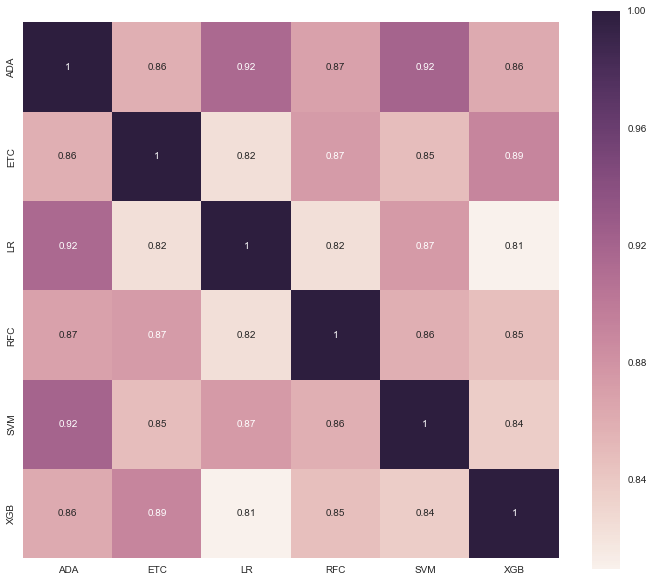

In [36]:
plt.figure(figsize=(12,10))
foo = sns.heatmap(base_predictions_train.corr(), vmax=1.0, square=True, annot=True)

In [37]:
X_train_ST = np.concatenate(( 
    oof_predictions_train_LR, 
    oof_predictions_train_SVM, 
    oof_predictions_train_RFC, 
    oof_predictions_train_ETC, 
    oof_predictions_train_XGB,
    oof_predictions_train_ADA    
), axis=1)


In [38]:
X_train_ST.shape

(891, 6)

In [39]:
train_labels.shape

(891,)

In [40]:
test_ST = np.concatenate((
    model_LR.predict(test.drop('PassengerId', axis=1)).reshape(-1, 1),
    model_SVM.predict(test.drop('PassengerId', axis=1)).reshape(-1, 1),
    model_RFC.predict(test.drop('PassengerId', axis=1)).reshape(-1, 1),
    model_ETC.predict(test.drop('PassengerId', axis=1)).reshape(-1, 1),
    model_XGB.predict(test.drop('PassengerId', axis=1)).reshape(-1, 1),
    model_ADA.predict(test.drop('PassengerId', axis=1)).reshape(-1, 1)    
), axis=1)    

In [41]:
model_XGB_ST = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 5,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1)
model_XGB_ST.fit(X_train_ST, train_labels)
stack_pred = model_XGB_ST.predict(test_ST)

In [42]:
scores_XGB_ST = cross_val_score(model_XGB_ST, X_train_ST, train_labels, cv=5)
print(scores_XGB_ST)
print("Mean score = %.3f, Std deviation = %.3f"%(np.mean(scores_XGB_ST),np.std(scores_XGB_ST)))

[ 0.81564246  0.81564246  0.84831461  0.78651685  0.85875706]
Mean score = 0.825, Std deviation = 0.026


# Retrain on complete dataset

In [43]:
# model_LR.fit(X, y)
# model_SVM.fit(X, y)
# model_RFC.fit(X, y)
# model_ETC.fit(X, y)
# model_XGB.fit(X, y)
# ensemble_Voting.fit(X, y)

# Submission

In [49]:
ids = test['PassengerId']
# predictions = model_XGB_ST.predict(test.drop('PassengerId', axis=1))
predictions = ensemble_Voting.predict(test.drop('PassengerId', axis=1))
# predictions = stack_pred

submission = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
submission.sample(10)

,PassengerId,Survived
337,1229,0
141,1033,1
63,955,1
98,990,1
73,965,1
251,1143,0
329,1221,0
36,928,0
18,910,1
356,1248,1


In [50]:
submission.to_csv('data/titanic/submission.csv', index=False)